## **Import libraries**

In [1]:
import numpy as np
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras 
from keras import layers
from keras import Input

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Input, BatchNormalization,Conv2DTranspose,UpSampling2D, LeakyReLU,Reshape
from keras.optimizers import Adam ,RMSprop
import cv2
import os
from tqdm import tqdm
import re
from PIL import Image 
from tensorflow.keras.utils import img_to_array

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

##  Load the data

In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# Change size of the image
SIZE = 128
image = []
path = '../input/face-mask-lite-dataset/without_mask'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
        if i == 'seed10000.png':
            break
        else:    
            img = cv2.imread(path + '/'+i,1)
            #  convert BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = (img - 127.5) / 127.5
            imh = img.astype(float)
            image.append(img_to_array(img))
            

100%|██████████| 10000/10000 [10:11<00:00, 16.34it/s]


##  Data Visualization

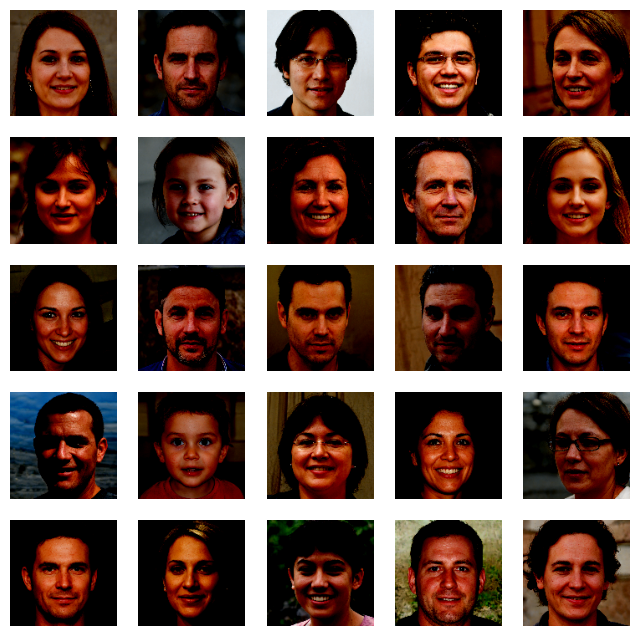

In [3]:
_,ax = plt.subplots(5,5, figsize = (8,8)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(image[5*i+j])
        ax[i,j].axis('off')

In [4]:
data = np.array(image)
print(data.shape)

(10000, 128, 128, 3)


In [5]:
batch_size = 32
dataset=tf.data.Dataset.from_tensor_slices(np.array(image)).batch(batch_size)

## model Architect

In [6]:
#discriminator
def discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((128, 128, 3)))

    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    return model

discriminator = discriminator()
print(discriminator.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       6144      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       262144    
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0

In [7]:
#generator
latent_dim = 100
def generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128*128*3, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.Reshape((128,128,3)))

    model.add(tf.keras.layers.Conv2D(128,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))

    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(256,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))

    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))

    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))

    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))

    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))

    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2DTranspose(3,4,strides = 1, padding = 'same',activation = 'tanh'))



    return model


generator = generator()
print(generator.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 49152)             4915200   
                                                                 
 reshape (Reshape)           (None, 128, 128, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 128)     6144      
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 128)       262144    
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                      

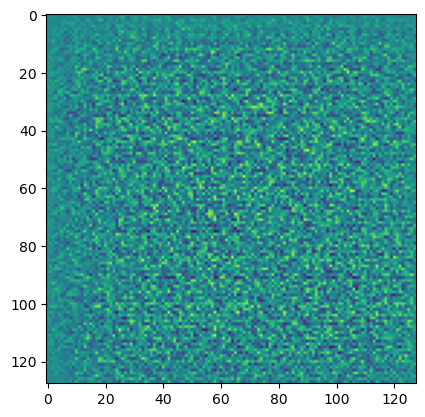

In [8]:
#before train
noise = np.random.normal(-1,1,(1,100))
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

In [9]:

# optimizer
optimizer = tf.keras.optimizers.legacy.RMSprop(
        learning_rate=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [10]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    return fake_loss + real_loss

### **training model**

In [11]:
# train
def train_steps(images):
    noise = np.random.normal(0,1,(batch_size,latent_dim))
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)
        
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)
        
        
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)    
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))
    
    loss = {'gen loss':gen_loss,
           'disc loss': dis_loss}
    return loss

In [12]:
latent_dim = 100
#function to plot generated images
def plot_generated_images(square = 5, epochs = 0):
    
    
    plt.figure(figsize = (10,10))
    for i in range(square * square):
        if epochs != 0: 
            if(i == square //2):
                plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize = 32, color = 'black')
        plt.subplot(square, square, i+1)
        noise = np.random.normal(0,1,(1,latent_dim))
        img = generator(noise)
        plt.imshow(np.clip((img[0,...]+1)/2, 0, 1))

        plt.xticks([])
        plt.yticks([])
        plt.grid()

In [13]:

import time
def train(epochs,dataset):
    
    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
        print(" Time:{}".format(np.round(time.time() - start),2)) 
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen loss'],loss['disc loss']))

## **Train model** 

In [14]:
train(20,dataset)


Epoch : 1


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 Time:290.0
Generator Loss: 1.2232353687286377 Discriminator Loss: 0.7618696689605713

Epoch : 2
 Time:281.0
Generator Loss: 0.59926837682724 Discriminator Loss: 1.454757571220398

Epoch : 3
 Time:281.0
Generator Loss: 0.5312163233757019 Discriminator Loss: 1.4760253429412842

Epoch : 4
 Time:281.0
Generator Loss: 0.6700804233551025 Discriminator Loss: 1.1450787782669067

Epoch : 5
 Time:281.0
Generator Loss: 0.6326004862785339 Discriminator Loss: 1.186072587966919

Epoch : 6
 Time:281.0
Generator Loss: 0.7092082500457764 Discriminator Loss: 1.170581340789795

Epoch : 7
 Time:281.0
Generator Loss: 0.5865207314491272 Discriminator Loss: 1.176328420639038

Epoch : 8
 Time:281.0
Generator Loss: 0.5529289245605469 Discriminator Loss: 1.1728383302688599

Epoch : 9
 Time:281.0
Generator Loss: 0.5605541467666626 Discriminator Loss: 1.3144148588180542

Epoch : 10
 Time:281.0
Generator Loss: 1.0353913307189941 Discriminator Loss: 1.0253568887710571

Epoch : 11
 Time:322.0
Generator Loss: 0.4835

## plot generated image 

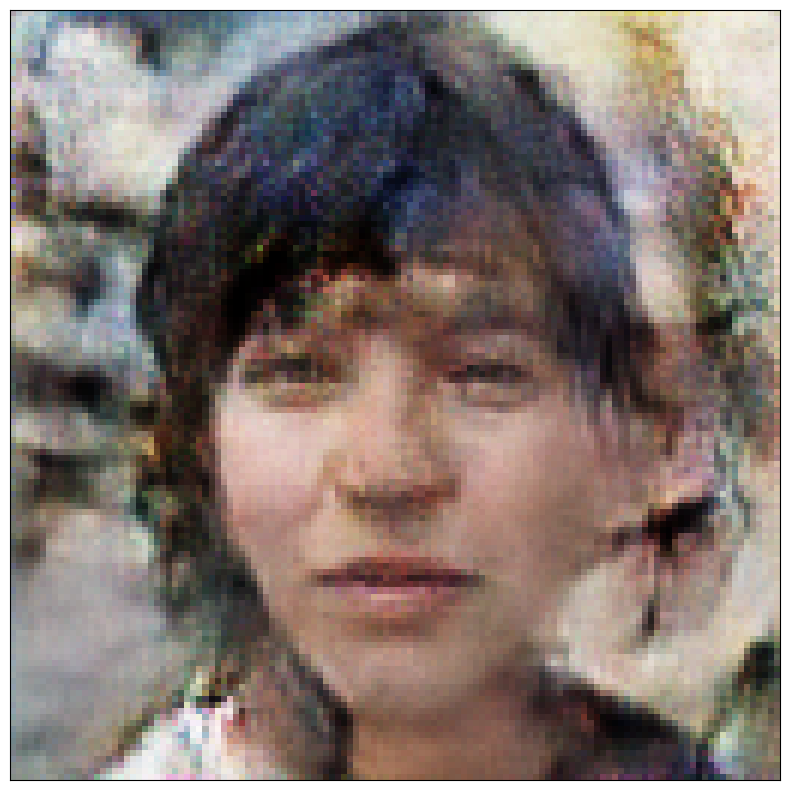

In [15]:
plot_generated_images(1)

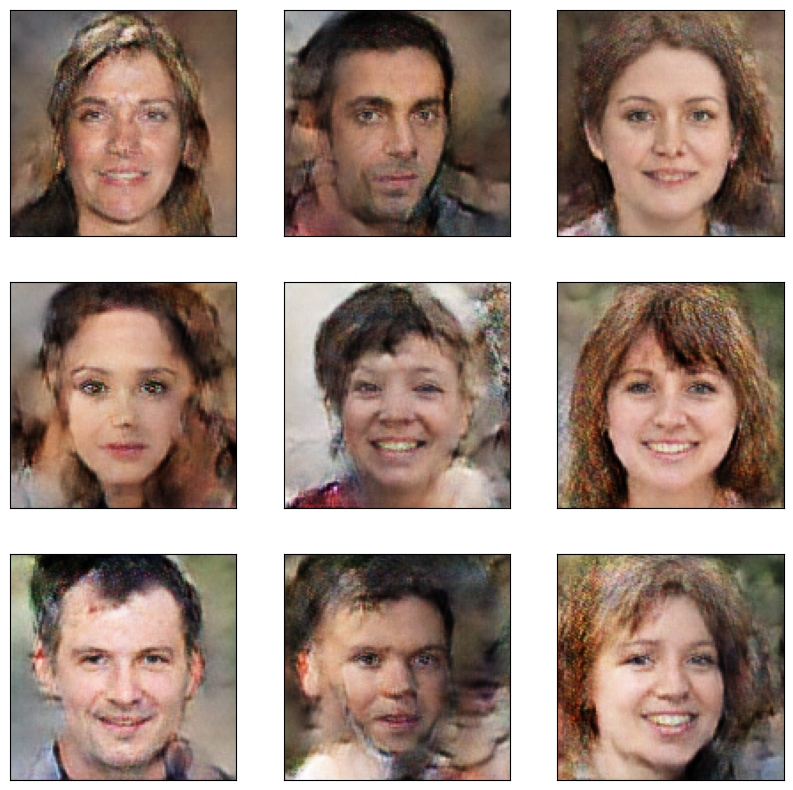

In [16]:
plot_generated_images(3)

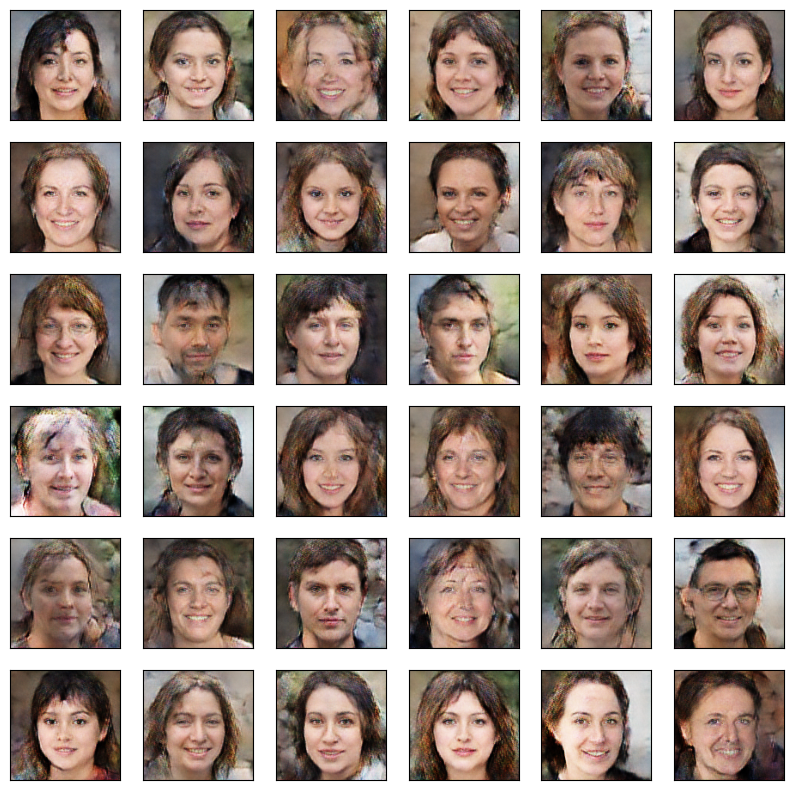

In [17]:
plot_generated_images(6)

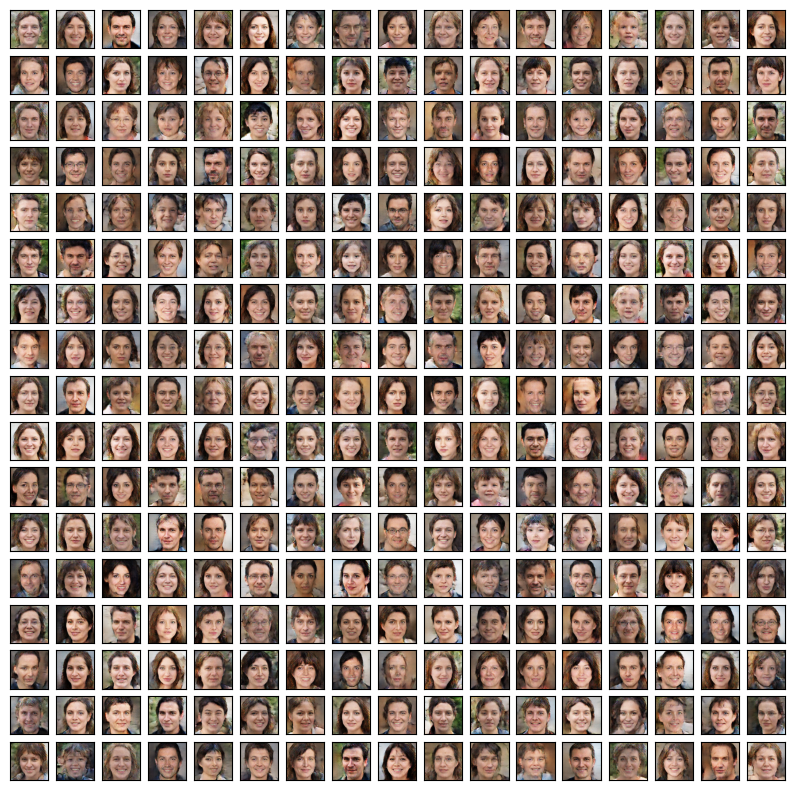

In [18]:
plot_generated_images(17)